In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as skl_model_selection #for splitting datasets
import sklearn.metrics as skl_metrics
from sklearn.datasets import make_moons #for testing nn

from time import time
import copy

In [3]:
#handler function to make easier the choice's logic 
def activations(f):
        act = {
            'sigmoid': (lambda x: sigmoid(x), lambda x: d_sigmoid(x)),
            'tanh': (lambda x: tanh(x), lambda x: d_tanh(x)),
            'reLU': (lambda x: 0 if(x<0) else x, lambda x: 0 if(x<0) else 1)
        }
        return act[f]

#implementation of activation functions
def sigmoid(x):
    return 1/(1+np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))
#
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def d_tanh(x):
    return 1 - (tanh(x) * tanh(x))

In [4]:
#get execution time (benchmark's purpose)
class Timer:
    def __init__(self):
        pass
    
    def start(self):
        self.time = time()
    
    def stop(self):
        self.delta = time() - self.time
    
    def get(self):
        return self.delta

In [5]:
#Layer's attributes:
    #input - the input to the layer
    #net - the network input of the layer (dot product between input and weights)
    #out - the outuput of the layer(= f(net))

    #f - the activation function to use
    #d_f - the derivative of the activation function (doesn't always exist)

    #num_units - how many units in the layer
    #input_size - how many input per unit

    #weights - how many weights per unit
    #d_weights - the values to apply to the weights during training in order to modify them
    #bias - the bias applied to the layer

class Layer:
    def __init__(self, num_units, pair_f, input_size): #pair_f = (f, d_f)
        np.random.seed(0) #to remove, debug's purpose
        
        self.f = pair_f[0]
        self.d_f = pair_f[1]
        self.num_units = num_units 
        self.input_size = input_size
        self.weights = np.random.rand(input_size, num_units)
        self.bias = np.random.rand(1, num_units)

In [6]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
    
    #Adding input layer(first hidden layer): you must specify the input_size
    #Adding hidden/output layer: if the layer is dense, the input_size is inferred from the previous layer
    def add_layer(self, l, num_units, f, input_size=None):
        if(l == "dense" or l == "Dense" or l == "d" or l == "D"):
            if(input_size == None):
                input_size = self.layers[-1].num_units
            self.layers.append(Layer(num_units, activations(f), input_size))
        
    def feed_forward(self, batch):
        current_input = batch
        for l in self.layers:
            l.input = current_input
            l.net = np.dot(l.input, l.weights) + l.bias # dot(in,w)+bias
            l.out = l.f(l.net)
            
            current_input = l.out
        return current_input
    
    def back_propagation(self, FF_output, targets, lr):
        err_signal=0
        bp=0
            
        self.layers.reverse()
        for index,l in enumerate(self.layers):
            #weight update & backprop sum
            if(index==0): #OUTPUT LAYER
                err = targets - FF_output
                err_signal = err * l.d_f(l.net)
                l.d_weights = np.dot(l.input.T, err_signal)
                
                bp = err_signal * l.weights.T
            else: #HIDDEN LAYERS
                err_signal = err * l.d_f(l.net)
                l.d_weights = np.dot(l.input.T, err_signal)
                
                bp = err_signal
            l.weights += lr * l.d_weights
            
            #bias update
            l.bias += np.sum(lr*err_signal, axis=0)
        self.layers.reverse()
        
        #compute loss and accuracy
        loss = np.sum(err, axis=0)
        accuracy = self.get_accuracy(FF_output, targets)
        
        return loss, accuracy
    
    def train(self,batch, targets, lr):
        return self.back_propagation(self.feed_forward(batch), targets, lr)
        
    def fit(self, dataset, targets, lr, test_size=0.5, epochs=1): 
        timer = Timer()
        timer.start()
            
        if test_size < 0.0 or test_size >= 1.0:
            print("ERROR, test_size needs to be between 0.0 and 1.0 (excluded)")
            return -1
        train_set, valid_set, train_targets, valid_targets = skl_model_selection.train_test_split(dataset, targets.T, test_size=test_size)
        tr_losses = []
        tr_accuracies = []
        
        patience=10
        best_accuracy = float("-inf")
        best_loss = 0
        best_model = 0
        vl_losses = []
        vl_accuracies = []
        running = True
        
        for i in range(0, epochs):
            if running == False:
                break
            
            tr_loss, tr_accuracy = self.train(train_set, train_targets, lr)
            tr_losses.append(tr_loss)
            tr_accuracies.append(tr_accuracy)
            
            
            if valid_set.size != 0 and valid_targets.size !=0:
                vl_loss, vl_accuracy = self.evaluate(valid_set, valid_targets)
                vl_losses.append(vl_loss)
                vl_accuracies.append(vl_accuracy)
                
                if vl_accuracy >= 0.99:
                    print("vl_accuracy>=0.99: break at epoch ", i)
                    print(tr_loss, " ", tr_accuracy)
                    running = False
                    break;
                #print("tr ", tr_accuracy, " vl ", vl_accuracy)
                '''
                if(vl_accuracy > best_accuracy):
                    best_accuracy = vl_accuracy
                    best_loss = vl_loss
                    best_model = copy.deepcopy(self)
                    patience=10
                else:
                    if(patience != 0):
                        patience = patience - 1
                    else:
                        self = best_model
                        print("lost patience: break at epoch ", i)
                        break;
                '''
            #print("epoch ", i, "\nerr_tot \n", loss)
        print("tr - loss ", tr_loss, " accuracy ", tr_accuracy)
        print("vl - loss ", vl_loss, " accuracy ", vl_accuracy)
            
        plt.figure(figsize=(15, 10))
        plt.subplot(211)
        plt.plot(range(2, len(tr_losses)+2), tr_losses, 'r-', label="tr_loss")
        plt.plot(range(2, len(vl_losses)+2), vl_losses, 'b-', label="vl_loss")
        #plt.xticks(np.arange(0, epochs, step=10))
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title("loss")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='best', fontsize=15)
        
        plt.subplot(212)
        plt.plot(range(2, len(tr_accuracies)+2), tr_accuracies, 'r-', label="tr_accuracy")
        plt.plot(range(2, len(vl_accuracies)+2), vl_accuracies, 'b-', label="vl_accuracy")
        #plt.xticks(np.arange(0, epochs, step=10))
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.title("accuracy")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='best', fontsize=15)
        #print("epoch ", i, "\nerr_tot \n", tr_loss)
        timer.stop()
        print("elapsed: \n", timer.get(), " ms")
    
    def evaluate(self, dataset, targets):
        out = self.feed_forward(dataset)
        err = targets - out
        loss = np.sum(err, axis=0)
        accuracy = self.get_accuracy(out, targets)
        
        return loss, accuracy
            
    def predict(self, dataset):
        out = self.feed_forward(dataset)
        return out
    
    def get_accuracy(self, output, targets):
        rounded = np.around(output)
        return skl_metrics.accuracy_score(targets, rounded)
        #accuracy = (rounded.size - np.count_nonzero(rounded))/rounded.size
        #return accuracy
        
    def print_weights(self, label="w"):
        for i in range(0, len(nn.layers)):
            print(label, ": layer ",i)
            print(nn.layers[i].weights)
            print(nn.layers[i].bias)

tr - loss  [-0.02356248]  accuracy  1.0
vl - loss  [1.930915]  accuracy  0.3333333333333333
elapsed: 
 2.157491683959961  ms


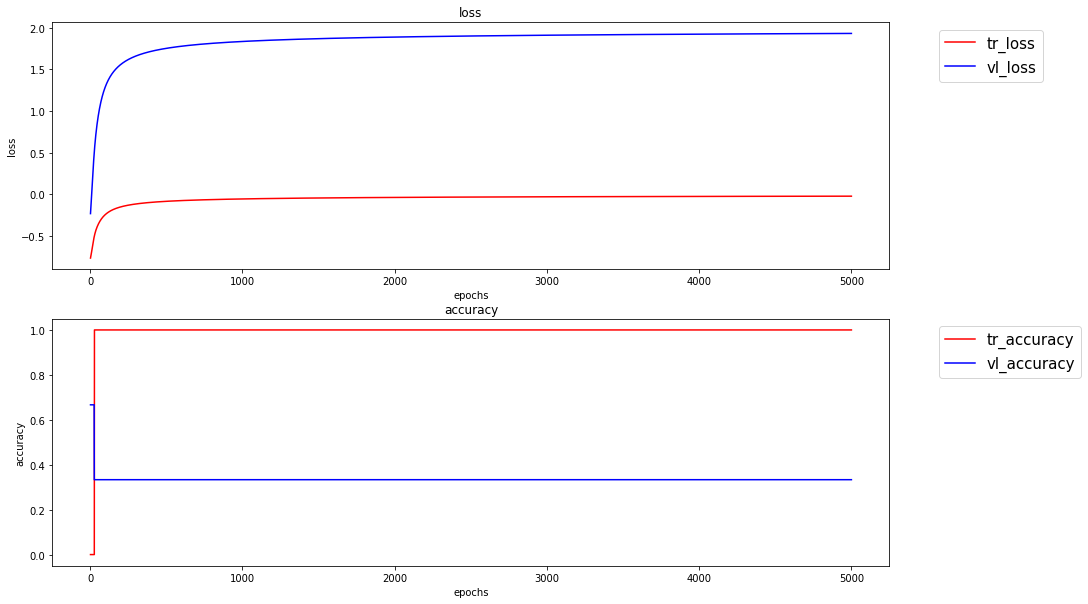

In [6]:
#XOR PROBLEM
dataset = np.array([[0,0], [0,1],[1,0],[1,1]])
targets = np.array([[0,1,1,0]])

#the neural network
nn = NeuralNetwork()
nn.add_layer('dense', 1, 'sigmoid', dataset.shape[1]) #input layer
#nn.add_layer('dense', 4, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')

#fit and predict
nn.fit(dataset, targets, 0.2, test_size=0.6, epochs=5000)
#nn.predict(np.array([[1,1], [1,0], [0,1], [0,0]]))

tr - loss  [-0.09587194]  accuracy  1.0
vl - loss  [0.84030174]  accuracy  0.8
elapsed: 
 0.5645883083343506  ms


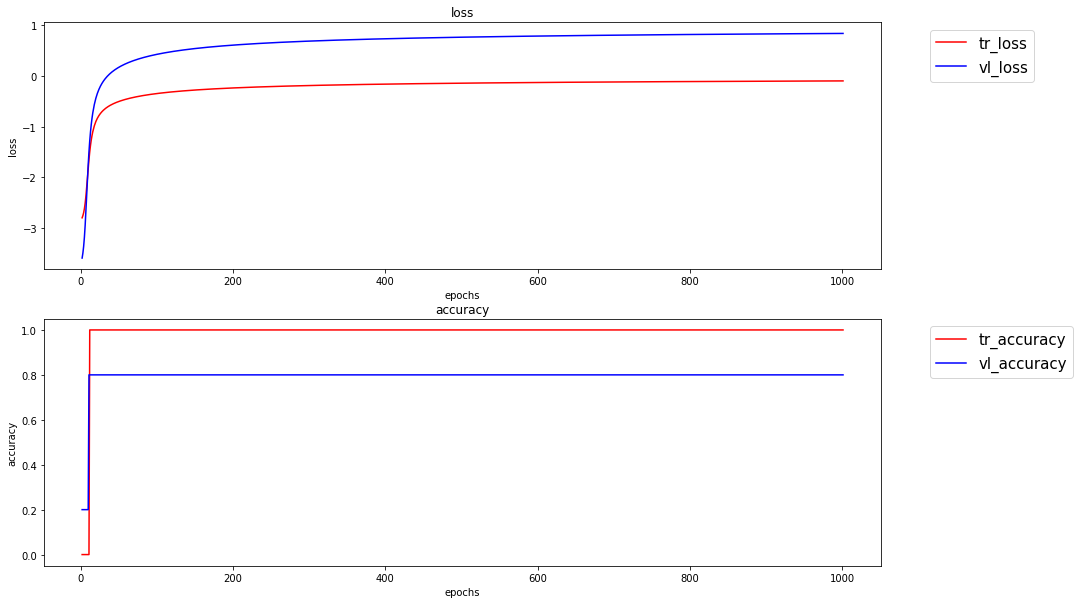

In [28]:
#AND PROBLEM WITH 3 VAR
dataset = np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]])
targets = np.array([[0,0,0,0,0,0,0,1]])

#the neural network
nn = NeuralNetwork()
nn.add_layer('dense', 1, 'sigmoid', dataset.shape[1]) #input layer
nn.add_layer('dense', 4, 'sigmoid')
nn.add_layer('dense', 4, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')

#fit and predict
nn.fit(dataset, targets, lr=0.2, test_size=0.6, epochs= 1000)
#nn.predict(np.array([[1,1,1], [0,1,0], [0,0,0]]))

tr - loss  [0.01821441]  accuracy  1.0
vl - loss  [-1.97252866]  accuracy  0.3333333333333333
elapsed: 
 0.9317665100097656  ms


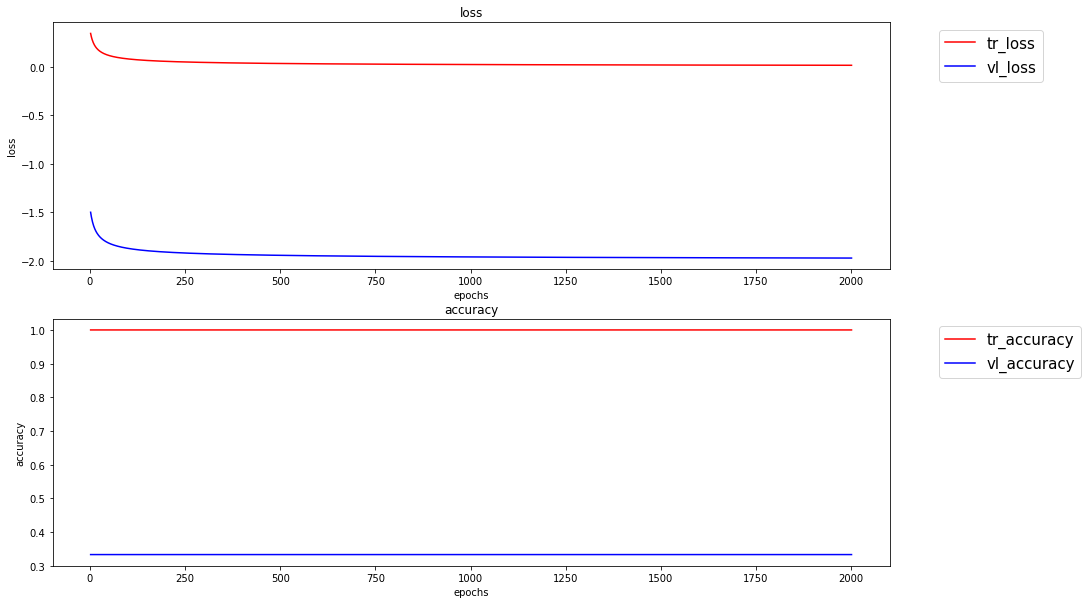

In [29]:
#??
dataset = np.array([[0,1,0],[0,0,1],[1,0,0],[1,1,0],[1,1,1]])
targets = np.array([[1,0,0,1,1]])

#the neural network
nn = NeuralNetwork()
nn.add_layer('dense', 1, 'sigmoid', dataset.shape[1]) #input layer
nn.add_layer('dense', 2, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')

nn.fit(dataset, targets, 0.5, epochs=2000)

In [7]:
#MONK1 PROBLEM

train_set = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks/monks1-train.txt", delimiter=" ", dtype="int")[:,1:-1] #rimuove la colonna nan alla fine
train_targets = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks/monks1-train.txt", delimiter=" ", dtype="int")[:,0:1].T

test_set = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks/monks1-test.txt", delimiter=" ", dtype="int") [:,1:-1] #rimuove targets e colonna nan 
test_targets = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks/monks1-test.txt", delimiter=" ", dtype="int") [:,0:1].T

vl_accuracy>=0.99: break at epoch  1885
[-0.25933612]   1.0
tr - loss  [-0.25933612]  accuracy  1.0
vl - loss  [-0.59923476]  accuracy  1.0
elapsed: 
 1.3155467510223389  ms


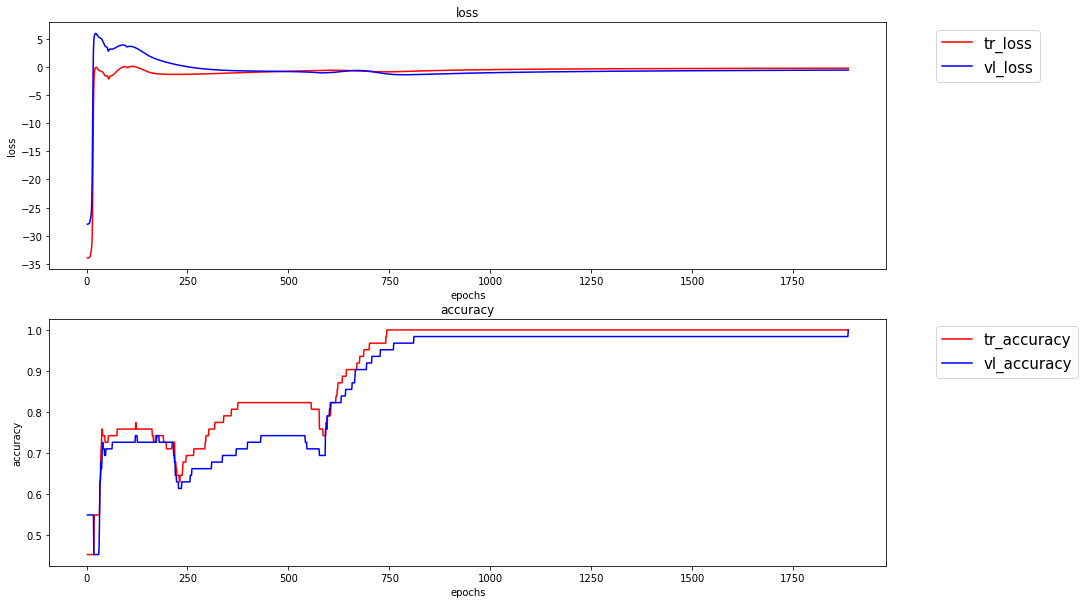

In [8]:
nn = NeuralNetwork()
nn.add_layer('dense', 10, 'sigmoid', train_set.shape[1]) #input layer
nn.add_layer('dense', 10, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')

nn.fit(train_set, train_targets, 0.05, test_size=0.5, epochs=2000) #lr=0.05 test_size=0.5 epochs=2000

In [9]:
l,a = nn.evaluate(test_set, test_targets.T)
print(l, a)

[-5.72653713] 0.9814814814814815


In [10]:
#MONK2 PROBLEM
train_set = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks/monks2-train.txt", delimiter=" ", dtype="int")[:,1:-1] #rimuove la colonna nan alla fine
train_targets = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks/monks2-train.txt", delimiter=" ", dtype="int")[:,0:1].T

test_set = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks/monks2-test.txt", delimiter=" ", dtype="int") [:,1:-1] #rimuove targets e colonna nan 
test_targets = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks/monks2-test.txt", delimiter=" ", dtype="int") [:,0:1].T

tr - loss  [-0.70609527]  accuracy  0.7288135593220338
vl - loss  [8.04422799]  accuracy  0.49019607843137253
elapsed: 
 1.6230456829071045  ms


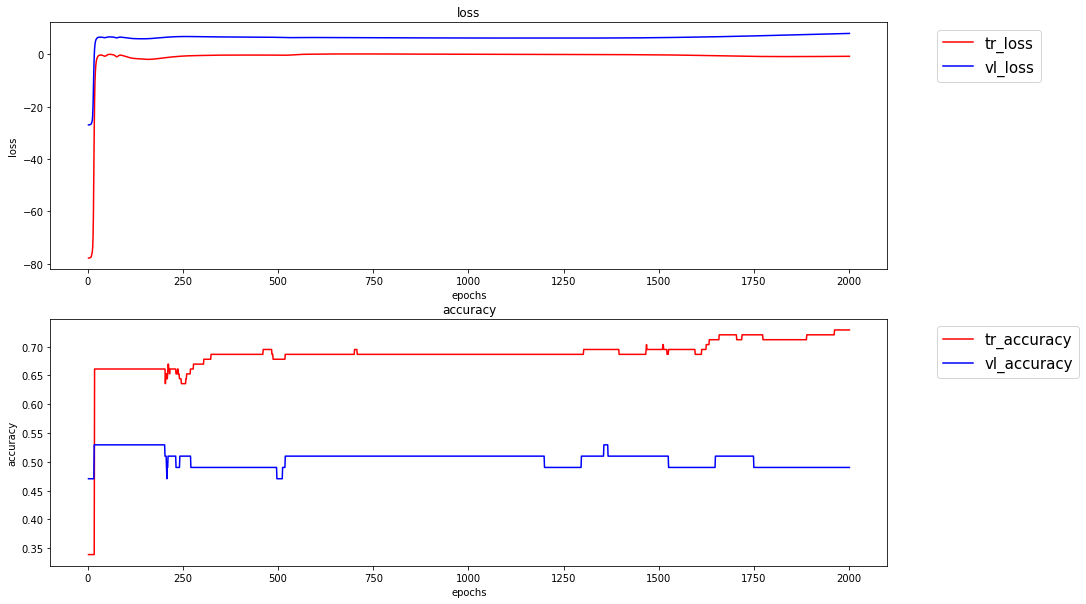

In [28]:
nn = NeuralNetwork()
nn.add_layer('dense', 10, 'sigmoid', train_set.shape[1]) #input layer
nn.add_layer('dense', 10, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')

nn.fit(train_set, train_targets, 0.02, test_size=0.3, epochs=2000)

In [29]:
l,a = nn.evaluate(test_set, test_targets.T)
print(l, a)

[-4.10132994] 0.625


tr - loss  [-2.71794725]  accuracy  0.8986666666666666
vl - loss  [0.38051814]  accuracy  0.872
elapsed: 
 0.7519633769989014  ms


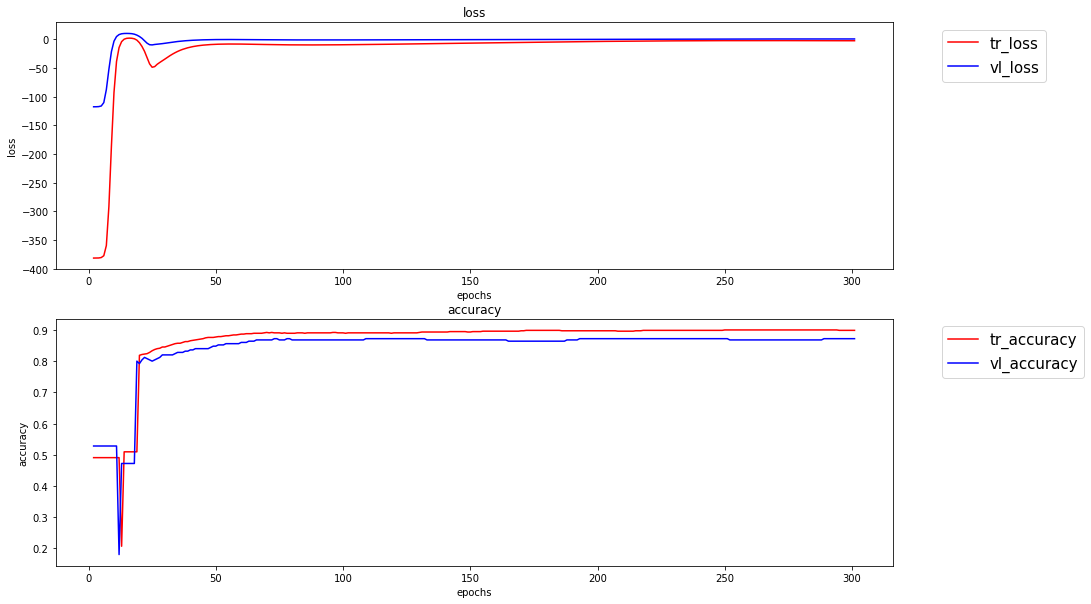

In [41]:
dataset, targets = make_moons(n_samples=1000)
targets=targets.reshape(1, targets.size)

nn = NeuralNetwork()
nn.add_layer('dense', 5, 'sigmoid', dataset.shape[1]) #input layer
nn.add_layer('dense', 20, 'sigmoid')
nn.add_layer('dense', 10, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')
#lr = 0.1 or o.2 with 1000 sample = disaster
#with 0,01 is okay
nn.fit(dataset, targets, 0.01, 0.25, 300) #0.1 0.01 1 10

test_set, test_targets = make_moons(n_samples=20)

In [42]:
test_targets=test_targets.reshape(1, test_targets.size)

nn.evaluate(test_set, test_targets.T)

(array([-0.00468658]), 0.85)